In [1]:
import torch
from datasets import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

d:\anaconda\envs\transformers\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
ds = load_dataset('json', data_files='./data/nlpcc_data.json',split='train[:20000]')
ds


Dataset({
    features: ['title', 'content'],
    num_rows: 20000
})

In [10]:
ds = ds.train_test_split(5000)
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'content'],
        num_rows: 15000
    })
    test: Dataset({
        features: ['title', 'content'],
        num_rows: 5000
    })
})

In [4]:
ds["train"][0]

{'title': '组图:国内首度公开日军轰炸延安图像,回应网上“日军不轰炸延安”的质疑;资料显示日军曾在延安上空投重磅炸弹。',
 'content': '重庆晨报任明勇2015-07-0109:03北碚区档案馆公开的图片有力地回应了网络上“日军不轰炸延安”的质疑,还披露了一批珍贵资料图为日军随军记者拍摄,日军正在观测被我军地雷炸毁掀翻的汽车。日军随军记者1939年10月拍摄的佐濑航空部队轰炸延安图。重庆晨报记者高科翻拍这些照片,再现了我党领导的敌后抗战重庆晨报记者任明勇报道“日军为何不轰炸延安,尽炸重庆?”这是网上一些人讨论抗日问题时,极常见的一种质疑。“很明显,这种质疑不成立。”昨天举行的“中国抗战的中流砥柱——日本档案再现共产党领导的敌后抗战”新闻发布会上,北碚区档案馆馆长冯琰展示了一张“日军轰炸延安”图片。这是国内首次公开的“日军轰炸延安”图。同时,北碚区档案馆还披露了一批珍贵档案,再现了中国共产党领导的敌后抗战。“这些珍贵档案史料,都是第一次披露。”日军不轰炸延安的质疑不成立冯琰介绍,3年前他们就开始征集抗战档案,截至目前,北碚区档案馆征集进馆的抗战史料有上百册,有纪念勋章、抗战有功荣誉证书、共产党领导的敌后抗日根据地建设等史料。冯琰说,这张图片很好地回应了网络质疑:日军飞机为何不轰炸延安,尽炸重庆?而且查阅史料,此种质疑也并不成立。日本政府一直认为中国共产党在发动和组织群众抗日方面拥有巨大影响力。所以,日军在发动正面侵略攻势时,同样将魔爪伸向共产党领导的敌后抗日中心——延安。只是由于延安人烟稀少,缺少重大战略目标,日军轰炸次数大大少于重庆。日军曾在延安上空投重磅炸弹冯琰提供的这张照片,是北碚区档案馆征集到的日本朝日新闻社随军记者1939年10月拍摄的日本佐濑航空部队轰炸延安图。当年10月15日,日军71架次飞机,分四批轮番疯狂轰炸延安。上午9时,日军36架轰炸机空袭延安,投弹100多枚。下午2时,日军35架轰炸机分三批轮流轰炸,投下120多枚重磅炸弹,大批房屋倒塌着火,死10人、伤13人。图上可以清晰看到延安周围的陕北高原地形,平坦城市到处浓烟滚滚。北碚区档案馆还征集了由日本朝日新闻社采写的报道:“‘佐濑、铃木、松山’各部队在上午十一点半,对红色抗日根据点延安的长翔、共产党第八路军的兵营、陕西大学、共产大学以及第八路军的政治部、外交部,包括其他军事设

In [5]:
#数据处理
tokenizer = AutoTokenizer.from_pretrained('./t5base')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
def process_func(exmaples):
    contents = ["摘要生成: \n" + e for e in exmaples["content"]]#在T5格式中，输入文本会加上任务描述
    inputs = tokenizer(contents, max_length=512, truncation=True)
    labels = tokenizer(text_target=exmaples["title"], max_length=64, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs
#分词，构建词典，根据构建好的词典将分词处理后的数据做映射文本序列->数字序列，我们是以batch的方式把这个数据输入到模型中填充和截断
#填充和截断确保所有输入序列的长度一致,目的便于批量处理，提高计算效率和加速训练过程
#在许多深度学习模型中（尤其是基于RNN或Transformer的模型），要求每个输入序列的长度是固定的，以便进行批处理。如果输入序列长度不一致，模型就无法同时处理多个样本。

In [7]:
tokenized_ds = ds.map(process_func, batched=True)#对数据集ds应用指定的处理函数process_func,返回一个新的数据集对象
tokenized_ds

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map: 100%|██████████| 100/100 [00:00<00:00, 1978.05 examples/s]


DatasetDict({
    train: Dataset({
        features: ['title', 'content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    test: Dataset({
        features: ['title', 'content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [8]:
print(tokenized_ds['train']['input_ids'][0])

[7, 17965, 5353, 13, 7, 2747, 3496, 503, 737, 309, 3062, 2416, 114, 6074, 8666, 165, 280, 13, 5227, 512, 28962, 159, 4537, 1483, 1914, 5, 1952, 6742, 53, 4302, 10, 15112, 31, 9231, 20, 20755, 16329, 41, 5, 4945, 3, 89, 4572, 16748, 10340, 1303, 15730, 9231, 1356, 349, 1113, 2223, 3, 9231, 859, 11605, 60, 14, 349, 53, 1098, 3215, 5631, 18590, 1351, 5, 555, 4, 9231, 1356, 349, 1113, 743, 5375, 24, 165, 50, 2223, 5, 6086, 27653, 3565, 3213, 20755, 16329, 313, 4, 2747, 3496, 13975, 79, 459, 1351, 949, 155, 2126, 3, 13128, 7092, 1480, 14727, 2499, 37, 11299, 2747, 3496, 13975, 737, 309, 3062, 2342, 31, 9231, 3089, 20, 20755, 16329, 3, 1069, 3215, 2747, 3049, 315, 1933, 10186, 1768, 11355, 143, 40, 3, 1164, 5087, 569, 4945, 1835, 8062, 3, 199, 4945, 20, 1915, 515, 2681, 13242, 31, 75, 11299, 5, 16, 496, 27520, 2547, 876, 686, 4537, 13128, 13884, 14727, 2499, 37, 11299, 41, 15345, 23, 3, 512, 28962, 159, 4537, 1483, 1483, 122, 4273, 28000, 12577, 1821, 31, 9231, 20755, 16329, 41, 1952, 4, 315

In [9]:
print(tokenized_ds['train']['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [10]:
print(tokenized_ds['train']['labels'][0])

[7, 760, 313, 13, 712, 850, 370, 1914, 9231, 20755, 16329, 5481, 3, 4302, 1933, 31, 9231, 20, 20755, 16329, 41, 5, 4945, 26, 20384, 9231, 7247, 16329, 23, 495, 1198, 19991, 14853, 4, 1]


In [11]:
tokenizer.decode(tokenized_ds['train']['input_ids'][0])#eos_token这个标记用于指示文本序列的结束标记

'摘要生成: 重庆晨报任明勇2015-07-0109:03北碚区档案馆公开的图片有力地回应了网络上“日军不轰炸延安”的质疑,还披露了一批珍贵资料图为日军随军记者拍摄,日军正在观测被我军地雷炸毁掀翻的汽车。日军随军记者1939年10月拍摄的佐濑航空部队轰炸延安图。重庆晨报记者高科翻拍这些照片,再现了我党领导的敌后抗战重庆晨报记者任明勇报道“日军为何不轰炸延安,尽炸重庆?”这是网上一些人讨论抗日问题时,极常见的一种质疑。“很明显,这种质疑不成立。”昨天举行的“中国抗战的中流砥柱——日本档案再现共产党领导的敌后抗战”新闻发布会上,北碚区档案馆馆长冯琰展示了一张“日军轰炸延安”图片。这是国内首次公开的“日军轰炸延安”图。同时,北碚区档案馆还披露了一批珍贵档案,再现了中国共产党领导的敌后抗战。“这些珍贵档案史料,都是第一次披露。”日军不轰炸延安的质疑不成立冯琰介绍,3年前他们就开始征集抗战档案,截至目前,北碚区档案馆征集进馆的抗战史料有上百册,有纪念勋章、抗战有功荣誉证书、共产党领导的敌后抗日根据地建设等史料。冯琰说,这张图片很好地回应了网络质疑:日军飞机为何不轰炸延安,尽炸重庆?而且查阅史料,此种质疑也并不成立。日本政府一直认为中国共产党在发动和组织群众抗日方面拥有巨大影响力。所以,日军在发动正面侵略攻势时,同样将魔爪伸向共产党领导的敌后抗日中心——延安。只是由于延安人烟稀少,缺少重大战略目标,日军轰炸次数大大少于重庆。日军曾在延安上空投重磅炸弹冯琰提供的这张照片,是北碚区档案馆征集到的日本朝日新闻社随军记者1939年10月拍摄的日本佐濑航空部队轰炸延安图。当年10月15日,日军71架次飞机,分四批轮番疯狂轰炸延安。上午9时,日军36架轰炸机空袭延安,投弹100多枚。下午2时,日军35架轰炸机分三批轮流轰炸,投下120多枚重磅炸弹,大批房屋倒塌着火,死10人、伤13人。图上可以清晰看到延安周围的陕北高原地形,平坦城市到处</s>'

In [12]:
tokenizer.decode(tokenized_ds['train']['labels'][0])

'组图:国内首度公开日军轰炸延安图像,回应网上“日军不轰炸延安”的质疑;资料显示日军曾在延安上空投重磅炸弹。</s>'

In [13]:
#创建模型
model = AutoModelForSeq2SeqLM.from_pretrained('./t5base')

In [14]:
#创建评估函数
import numpy as np
from rouge_chinese import Rouge
rouge = Rouge()#初始化 ROUGE 评估器
def compute_metric(evalPred):
    # evalPred 包含两个部分，predictions：模型生成的预测结果（即生成的文本），labels：真实文本
    predictions, labels = evalPred
    decode_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decode_preds = [" ".join(p) for p in decode_preds]
    decode_labels = [" ".join(l) for l in decode_labels]
    scores = rouge.get_scores(decode_preds, decode_labels, avg=True)
    #decode_preds 是模型的预测文本列表，decode_labels 是参考标签文本列表，
    # avg=True：表示返回的分数是平均值（即所有样本的 ROUGE 分数的平均）。
    return {
        "rouge-1": scores["rouge-1"]["f"],
        "rouge-2": scores["rouge-2"]["f"],
        "rouge-l": scores["rouge-l"]["f"],
    }

#文本摘要通过计算 ROUGE 分数来衡量生成文本与参考文本之间的相似度，ROUGE-1 和 ROUGE-2 用于评估生成摘要的覆盖度，而 ROUGE-L 则评估摘要的结构和连贯性
#"rouge-1"：ROUGE-1 分数，计算单词级别的 F1 值。强调生成文本与参考文本在 单词 层面的相似性
#"rouge-2"：ROUGE-2 分数，表示二元组级别的 F1 值。强调生成文本和参考文本在 短语 层面的相似性
#"rouge-l"：ROUGE-L 分数，表示最长公共子序列（LCS）级别的 F1 值。强调生成文本与参考文本之间的 语义连贯性 和 结构一致性


In [15]:
#配置训练参数
args = Seq2SeqTrainingArguments(
    output_dir="./summary",#模型训练结果（如模型检查点和日志）保存的目录,保存了模型、日志、评估指标、配置文件等信息
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,#表示每 8 个批次才会更新一次梯度
    logging_steps=8,#设置每 8 个训练步骤记录一次日志。日志通常用于显示训练进度或评估指标。
    eval_strategy="epoch",#设置评估策略为按“epoch”进行评估，即每完成一个训练周期（epoch）后评估一次模型性能。
    save_strategy="epoch",#设置模型保存策略为按“epoch”进行保存，即每个训练周期结束时保存一次模型检查点。
    metric_for_best_model="rouge-l",#指定用于评估最佳模型的指标为 rouge-l
    predict_with_generate=True,#表示在评估时使用生成的文本作为预测结果,而不仅仅是基于标准的分类或回归推理
    num_train_epochs=6#设置训练的总轮数为 5，即整个数据集会被训练 5 次
)

In [16]:
#创建训练器
trainer = Seq2SeqTrainer(
    args=args,
    model=model,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metric,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer)
)
#DataCollatorForSeq2Seq 会处理变长序列的自动填充，从而可以批量处理。
#如果每个样本单独进行填充，那么每个输入序列的长度会变得更大，模型的计算和内存开销也会增大。特别是对于长序列来说，填充所带来的额外计算负担可能会显著影响训练效率。
#但是，如果将填充操作推迟到批处理阶段，模型只会根据批次中的最大长度来填充，而不是每个单独样本都进行填充，这样可以减少不必要的内存和计算消耗，提升训练和推理的效率。


C:\TEMP\ipykernel_7256\1373131255.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [17]:
#模型训练
trainer.train()

100%|██████████| 6/6 [04:04<00:00, 42.09s/it]d:\anaconda\envs\transformers\lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                             
100%|██████████| 6/6 [06:06<00:00, 42.09s/it]  

{'eval_loss': 4.531628131866455, 'eval_rouge-1': 0.24770881116044902, 'eval_rouge-2': 0.10712004538762379, 'eval_rouge-l': 0.18875668513178098, 'eval_runtime': 117.4426, 'eval_samples_per_second': 0.851, 'eval_steps_per_second': 0.111, 'epoch': 0.96}


100%|██████████| 6/6 [06:09<00:00, 61.64s/it]

{'train_runtime': 369.8672, 'train_samples_per_second': 0.541, 'train_steps_per_second': 0.016, 'train_loss': 52.36673482259115, 'epoch': 0.96}


TrainOutput(global_step=6, training_loss=52.36673482259115, metrics={'train_runtime': 369.8672, 'train_samples_per_second': 0.541, 'train_steps_per_second': 0.016, 'total_flos': 125358742499328.0, 'train_loss': 52.36673482259115, 'epoch': 0.96})

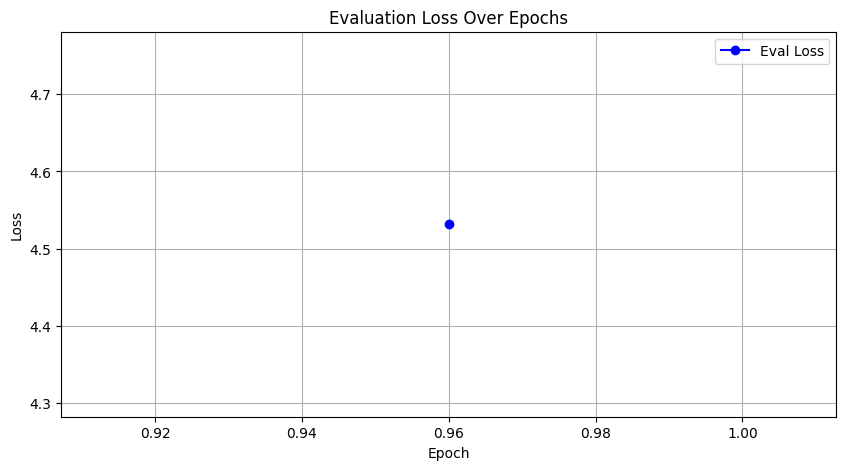

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 记录日志的列表
eval_losses = []
eval_rouge_1 = []
eval_rouge_2 = []
eval_rouge_l = []
epochs = []

# 假设在训练过程中，你在每次评估时将日志记录到这些列表中
for log in trainer.state.log_history:
    if 'eval_loss' in log:  # 如果是评估日志
        eval_losses.append(log['eval_loss'])
        eval_rouge_1.append(log['eval_rouge-1'])
        eval_rouge_2.append(log['eval_rouge-2'])
        eval_rouge_l.append(log['eval_rouge-l'])
        epochs.append(log['epoch'])
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_losses, label='Eval Loss', marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

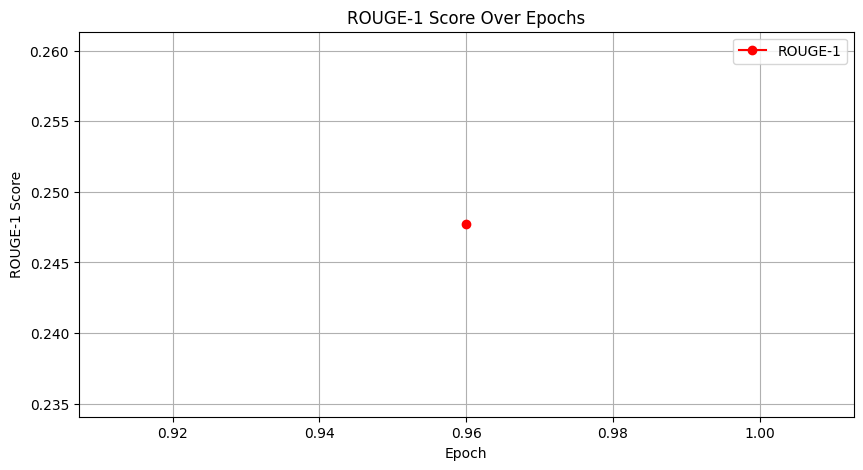

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_rouge_1, label='ROUGE-1', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('ROUGE-1 Score')
plt.title('ROUGE-1 Score Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

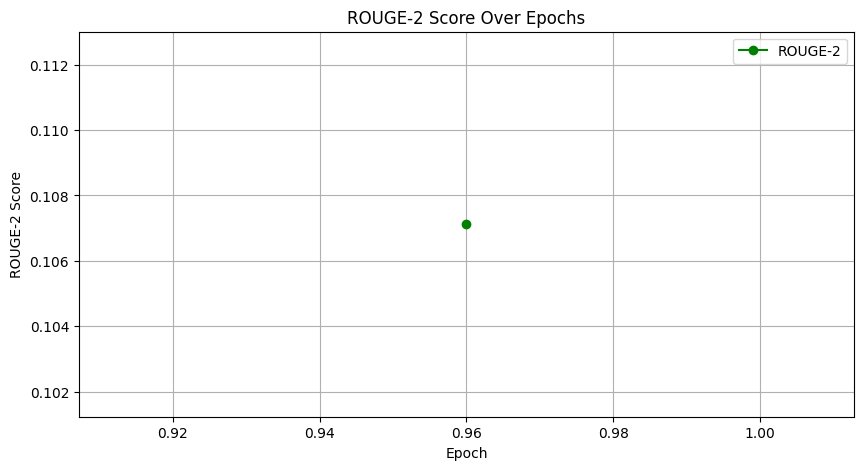

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_rouge_2, label='ROUGE-2', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('ROUGE-2 Score')
plt.title('ROUGE-2 Score Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

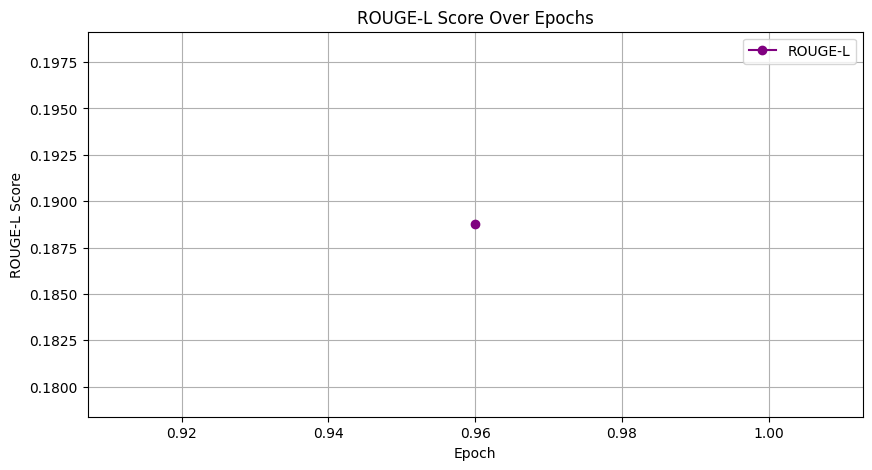

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_rouge_l, label='ROUGE-L', marker='o', color='purple')
plt.xlabel('Epoch')
plt.ylabel('ROUGE-L Score')
plt.title('ROUGE-L Score Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
#模型推理
from transformers import pipeline
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)
#任务类型是 文本到文本生,使用 GPU 进行推理
pipe("摘要生成:\n" + ds["test"][0]["content"], max_length=64, do_sample=True)
#传入输入文本，当 do_sample=True 时，生成过程会随机选择词汇表中的词汇进行生成，从而使得输出更加多样化

[{'generated_text': '致犯罪嫌疑人黄某。张某等六人,因殴打吴某、在南京当地一男子挑衅,致被害人,被殴打吴某,殴打吴某。10人,犯罪嫌疑人逃跑,后,遭殴打后,殴打吴某男子殴打吴某在麦当劳餐厅,被害人,造成嫌疑人重伤。'}]

In [21]:
ds["test"][0]["title"]

'山东招远6人在麦当劳搭讪女子遭拒,围殴女子致死,现场无人相救。6人目前已被捕。'